In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('Data\\names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
x = torch.randn(5000, 5)
w = torch.randn(5,10)/ (5**0.5)
a = x@w 
a.std()

tensor(0.9292)

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) #* (5/3)/( (n_embd*block_size) **0.5)#0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden), requires_grad=True)
bnbias = torch.zeros((1,n_hidden), requires_grad=True)
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [78]:
xx = bngain*(hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
xx.shape

torch.Size([32, 200])

In [122]:
# Initialize a parameter
WT = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print("Original W1:", WT)

# Create a list of parameters
parameters = [WT]

# Perform a gradient descent step incorrectly by reassigning W1
WT = WT - 0.1 * torch.tensor([0.1, 0.1, 0.1])  # This creates a new tensor
print("After reassignment W1:", WT)
print("Parameters list after reassignment:", parameters)


Original W1: tensor([1., 2., 3.], requires_grad=True)
After reassignment W1: tensor([0.9900, 1.9900, 2.9900], grad_fn=<SubBackward0>)
Parameters list after reassignment: [tensor([1., 2., 3.], requires_grad=True)]


In [7]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 100000: 3.3239
  10000/ 100000: 2.0845


In [157]:
import torch

# Create tensors with requires_grad=True
a = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
b = torch.tensor([100.0, 200.0, 300.0], requires_grad=True)

print("a.requires_grad:", a.requires_grad)  # True
print("b.requires_grad:", b.requires_grad)  # True

# Perform an operation inside torch.no_grad()
with torch.no_grad():
    c = a + b
    print("c.requires_grad inside torch.no_grad:", c.requires_grad)  # False (new tensor inside torch.no_grad)
    a.data = b + 2
    print("a.requires_grad inside torch.no_grad after data assignment:", a.requires_grad)  # True

# Check requires_grad status after torch.no_grad()
print("a.requires_grad after torch.no_grad:", a.requires_grad)  # True
print("b.requires_grad after torch.no_grad:", b.requires_grad)  # True
print("c.requires_grad after torch.no_grad:", c.requires_grad)  # True

a.requires_grad: True
b.requires_grad: True
c.requires_grad inside torch.no_grad: False
a.requires_grad inside torch.no_grad after data assignment: True
a.requires_grad after torch.no_grad: True
b.requires_grad after torch.no_grad: True
c.requires_grad after torch.no_grad: False


False

In [18]:
print(h.shape)
print(logits.shape)

torch.Size([32, 200])
torch.Size([32, 27])


pass
tensor(0.5974, grad_fn=<StdBackward0>)


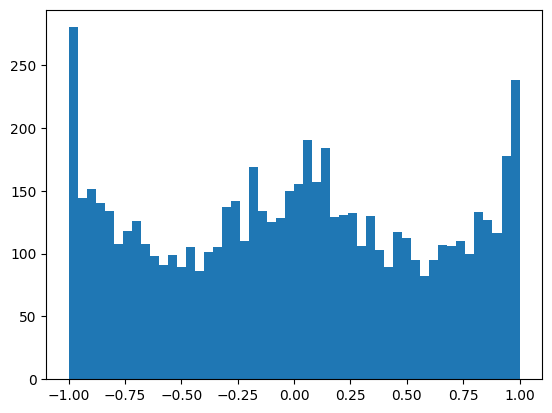

In [276]:
plt.hist(h.view(-1).tolist(), 50)
print('pass')
print(h.std())

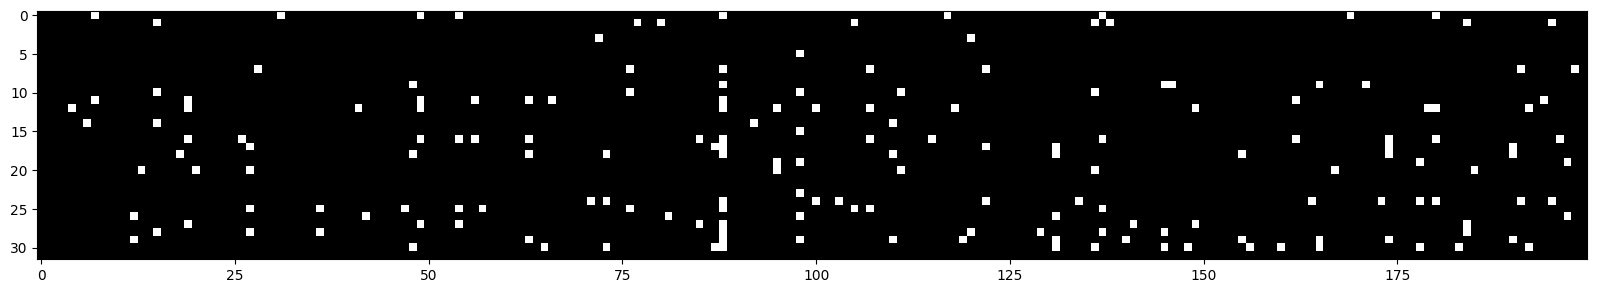

In [277]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap ='gray', interpolation='nearest')

In [36]:
min(hpreact.view(-1).tolist())


0.9999999999998128

In [60]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1458635330200195
val 2.209584951400757


In [68]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
    #   probs = torch.ones((1,27))*(1/27)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
madhayla.
ren.
ruthndraeg.
adelyn.
elin.
shi.
jen.
eden.
est.
aaraelyzion.
kamin.
shuberlyni.
jest.
jair.
jeniqueterian.
brence.
ryyah.
fael.
yuve.
myson.
daihil.
samya.
suf.
zakhlorine.
jare.
kaveah.
canord.


In [71]:
probs

tensor([[3.0247e-01, 2.3598e-01, 2.8690e-04, 2.2933e-03, 3.5597e-03, 1.8384e-01,
         1.2879e-04, 1.1266e-02, 7.2036e-03, 3.4332e-02, 7.7868e-04, 2.7600e-04,
         3.8652e-03, 1.4900e-03, 3.5154e-02, 8.6076e-02, 6.2674e-06, 5.9747e-05,
         1.2760e-02, 1.4250e-02, 2.4930e-04, 1.0075e-03, 5.5512e-05, 4.5509e-04,
         3.5158e-05, 6.1266e-02, 8.5744e-04]], grad_fn=<SoftmaxBackward0>)

In [42]:
F.cross_entropy(torch.tensor([[5,50,0,0]], dtype=torch.float32), torch.tensor([0]))

tensor(45.)

In [22]:
torch.log10(torch.tensor(27))

tensor(1.4314)

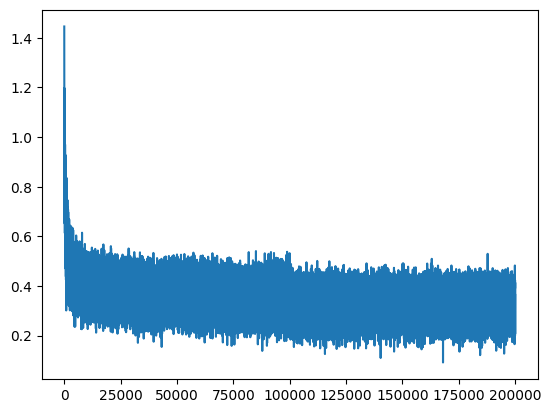

In [16]:
plt.plot(lossi)

In [20]:
print("EMB.shape  " , emb.shape)
print("hpreact   ", hpreact.shape)
hpreact.shape

EMB.shape   torch.Size([32, 3, 10])
hpreact    torch.Size([32, 200])


torch.Size([32, 200])

In [25]:
embcat.shape

torch.Size([32, 30])